# Proof or concept for speed-up by treating the norm of an XSPEC model specially



In [1]:
from sherpa.astro import ui
from sherpa.astro.xspec import XSapec, XSphabs
from sherpa.astro import xspec
from io import StringIO
import time
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from astropy.stats import sigma_clipped_stats

In [2]:
from sherpa.astro import xspec
xspec.get_xsversion()

'12.14.0k'

## XSPEC internal cache

In [3]:
en_bins = np.arange(0.2, 10., 0.01)
for i in range(5):
    apecmodel = XSapec()
    start_time = time.perf_counter()
    flux = apecmodel(xlo=en_bins[:-1], xhi=en_bins[1:])
    end_time = time.perf_counter()
    print(f"Time taken: {end_time-start_time:.2f} s")

/Users/guenther/code/sherpa/sherpa/astro/xspec/__init__.py:1465: FutureWarning: calc() requires pars,lo,hi arguments, sent 2 arguments
  warnings.warn(emsg, FutureWarning)


Reading APEC data from 3.0.9

Time taken: 0.27 s
Time taken: 0.02 s
Time taken: 0.02 s
Time taken: 0.02 s
Time taken: 0.02 s


As we can see, just running a model with the same input parameters several times is slow the first time and then much faster after that, even though we create a new model object every time. That means that the caching is internal to XSPEC itself, as the Sherpa cache is initialized every time we create a new model object.

In [4]:
for i in range(5):
    apecmodel = XSapec()
    apecmodel.kT = 3.45
    start_time = time.perf_counter()
    flux = apecmodel(xlo=en_bins[:-1], xhi=en_bins[1:])
    end_time = time.perf_counter()
    print(f"Time taken: {end_time - start_time:.2f} s")


Time taken: 0.08 s
Time taken: 0.01 s
Time taken: 0.01 s
Time taken: 0.01 s
Time taken: 0.01 s


If we change the model parameters, then the cache needs to be filled again, so the first call takes longer than the latter ones.

In [5]:
apecmodel = XSapec()
start_time = time.perf_counter()
flux = apecmodel(xlo=en_bins[:-1], xhi=en_bins[1:])
end_time = time.perf_counter()
print(f"Time taken: {end_time - start_time:.2f} s")

Time taken: 0.02 s


In [6]:
for i in range(5):
    apecmodel = XSapec()
    apecmodel.norm = 1/(i + 1)
    start_time = time.perf_counter()
    flux = apecmodel(xlo=en_bins[:-1], xhi=en_bins[1:])
    end_time = time.perf_counter()
    print(f"Time taken: {end_time - start_time:.2f} s")


Time taken: 0.02 s
Time taken: 0.02 s
Time taken: 0.02 s
Time taken: 0.07 s
Time taken: 0.02 s


In this experiment, we see that there is only a very small change in run-time for setting a new norm. Although the norm is different in every call, the run-time is almost the same. Curiously, it's not exactly the same, but it also is not as long in the case when physical parameters like the temperature are changed.

I don't know how many values XSPEC keeps in its internal cache (and I don't want to try that out here), but if we go back to a previously used parameter value, the result is still fast. I did a cursory glance that the XSPEC docs and can't find anything there, but it's possible that this is already implemented as part of APEC, which XSPEC just ingests.

### Considering the internal cache for the following benchmarks

That leads to two conclusions:

- When we benchmark run-times using similar datasets, the second run will always be faster unless we totally nuke XSPEC and restart the notebook.
- If we want to be even faster, we need to find a way to call XSPEC less overall. Sherpa's caching on top pf XSPEC's own caching might have a very limited effect for APEC models.


## Fits with real data

In [3]:
ui.load_pha(
    1, "../curated-test-data/Chandra/ACIS/acisf04487_001N023_r0009_pha3.fits.gz"
)
ui.load_pha(
    2, "../curated-test-data/Chandra/ACIS/acisf04487_001N023_r0009_pha3.fits.gz"
)

read ARF file ../curated-test-data/Chandra/ACIS/acisf04487_001N022_r0009_arf3.fits


read RMF file ../curated-test-data/Chandra/ACIS/acisf04487_001N022_r0009_rmf3.fits
read background file ../curated-test-data/Chandra/ACIS/acisf04487_001N023_r0009_pha3.fits
read ARF file ../curated-test-data/Chandra/ACIS/acisf04487_001N022_r0009_arf3.fits
read RMF file ../curated-test-data/Chandra/ACIS/acisf04487_001N022_r0009_rmf3.fits
read background file ../curated-test-data/Chandra/ACIS/acisf04487_001N023_r0009_pha3.fits


In [4]:
ui.group_counts(1, 5)
ui.group_counts(2, 5)
ui.ignore(None, 0.3)
ui.ignore(7, None)


dataset 1: 0.0073:14.9504 Energy (keV) (unchanged)
dataset 2: 0.0073:14.9504 Energy (keV) (unchanged)
dataset 1: 0.0073:14.9504 -> 0.5256:14.9504 Energy (keV)
dataset 2: 0.0073:14.9504 -> 0.5256:14.9504 Energy (keV)
dataset 1: 0.5256:14.9504 -> 0.5256:6.4678 Energy (keV)
dataset 2: 0.5256:14.9504 -> 0.5256:6.4678 Energy (keV)


### Setup of the first model, using standard XSPEC models

We are fitting two apec models with different temperatures and different absorption components. We set the starting values of the parameters to reasonable number such that the fit converges after a reasonable number of iterations.

In [5]:
abs1 = XSphabs("abs1")
abs2 = XSphabs("abs2")
apec1 = XSapec("apec1")
apec2 = XSapec("apec2")
model = abs1 * apec1 + abs2 * apec2


In [6]:
ui.set_source(1, model)

abs1.nH = 0.1
abs2.nH = 1
apec1.kT = 0.5
apec2.kT = 5
apec1.norm = 1e-2
apec2.norm = 1e-2



In [7]:
out = StringIO()

start_time = time.perf_counter()
ui.fit(1, outfile=out)
end_time = time.perf_counter()
print(end_time - start_time, "seconds")
txt = out.getvalue()


Reading APEC data from 3.0.9

Dataset               = 1
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 1.16757e+08
Final fit statistic   = 23.1913 at function evaluation 117
Data points           = 66
Degrees of freedom    = 60
Probability [Q-value] = 0.999995
Reduced statistic     = 0.386522
Change in statistic   = 1.16757e+08
   abs1.nH        0.708404     +/- 0.170232    
   apec1.kT       0.211462     +/- 0.0483091   
   apec1.norm     0.000324427  +/- 0.000440131 
   abs2.nH        2.54979      +/- 0.785303    
   apec2.kT       2.12737      +/- 0.613379    
   apec2.norm     0.000190664  +/- 7.07233e-05 
2.5476826670055743 seconds


In [12]:
out = StringIO()

start_time = time.perf_counter()
ui.fit(1, outfile=out)
end_time = time.perf_counter()
print(end_time - start_time, "seconds")
txt = out.getvalue()


Dataset               = 1
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 23.1913
Final fit statistic   = 23.1913 at function evaluation 8
Data points           = 66
Degrees of freedom    = 60
Probability [Q-value] = 0.999995
Reduced statistic     = 0.386522
Change in statistic   = 2.35533e-08
   abs1.nH        0.708377     +/- 0.170219    
   apec1.kT       0.211472     +/- 0.0483013   
   apec1.norm     0.000324343  +/- 0.000440291 
   abs2.nH        2.54977      +/- 0.785373    
   apec2.kT       2.12738      +/- 0.613325    
   apec2.norm     0.000190663  +/- 7.07136e-05 
0.13990775001002476 seconds


In [13]:
%prun -q -D output1.prof ui.fit(1)


Dataset               = 1
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 23.1913
Final fit statistic   = 23.1913 at function evaluation 15
Data points           = 66
Degrees of freedom    = 60
Probability [Q-value] = 0.999995
Reduced statistic     = 0.386522
Change in statistic   = 1.99573e-06
   abs1.nH        0.708311     +/- 0.170308    
   apec1.kT       0.211481     +/- 0.0483164   
   apec1.norm     0.000324206  +/- 0.000440041 
   abs2.nH        2.54952      +/- 0.785375    
   apec2.kT       2.12751      +/- 0.613428    
   apec2.norm     0.000190644  +/- 7.07152e-05 
 
*** Profile stats marshalled to file 'output1.prof'.


In [8]:
tab = Table.read(txt, format="ascii.commented_header")

### Freeze the norm in the vapec components

We use exactly the same model setup, except that we freeze the norm in the vapec components and instead use a Sherpa `Scale1D` model to model the norm. That way, the apec should not be recalculated if just the norm is changed.
Of course, the fitter might choose a different order to vary the parameters, but this is the most accurate way we have to compare the performance.

We again set the starting values of the parameters to the same values as in the previous model.

In [ ]:
from sherpa.models.basic import Scale1D

abs21 = XSphabs("abs21")
abs22 = XSphabs("abs22")
const21 = Scale1D("const1")
const22 = Scale1D("const2")
const21._use_caching = False
const22._use_caching = False
apec21 = XSapec("apec21")
apec22 = XSapec("apec22")
model2 = abs21 * const21 * apec21 + abs22 * const22 * apec22


In [10]:
ui.set_source(2, model2)

abs21.nH = 0.1
abs22.nH = 1
apec21.kT = 0.5
apec22.kT = 5
apec21.norm = 1
apec22.norm = 1
apec21.norm.freeze()
apec22.norm.freeze()
const21.c0 = 0.01
const22.c0 = 0.01


In [11]:


out = StringIO()

start_time2 = time.perf_counter()
ui.fit(2, outfile=out)
end_time2 = time.perf_counter()
print(end_time2 - start_time2, "seconds")
txt = out.getvalue()


Dataset               = 2
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 1.16757e+08
Final fit statistic   = 23.1913 at function evaluation 103
Data points           = 66
Degrees of freedom    = 60
Probability [Q-value] = 0.999995
Reduced statistic     = 0.386522
Change in statistic   = 1.16757e+08
   abs21.nH       0.708365     +/- 0.17028     
   const1.c0      0.000324383  +/- 0.000439932 
   apec21.kT      0.211461     +/- 0.0483555   
   abs22.nH       2.54963      +/- 0.785542    
   const2.c0      0.000190653  +/- 7.07243e-05 
   apec22.kT      2.12744      +/- 0.613513    
0.7318235409911722 seconds


In [18]:
%prun -q -D output2.prof ui.fit(2)


Dataset               = 2
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 23.1913
Final fit statistic   = 23.1913 at function evaluation 8
Data points           = 66
Degrees of freedom    = 60
Probability [Q-value] = 0.999995
Reduced statistic     = 0.386522
Change in statistic   = 3.70588e-07
   abs21.nH       0.708289     +/- 0.17023     
   const1.c0      0.000324157  +/- 0.000440171 
   apec21.kT      0.211485     +/- 0.0482879   
   abs22.nH       2.54953      +/- 0.785473    
   const2.c0      0.000190645  +/- 7.07167e-05 
   apec22.kT      2.1275       +/- 0.613396    
 
*** Profile stats marshalled to file 'output2.prof'.


In [12]:
tab2 = Table.read(txt, format="ascii.commented_header")


### Comparing the different fits

Looking at the output above, we can see that the fit results are virtually identical, except that in the second run the `Scale1D` models take the role of the normalizations.

Comparison of fitted values

In [20]:
ui.get_model(1)

<RSPModelPHA model instance 'apply_rmf(apply_arf(29715.734470358 * (abs1 * apec1 + abs2 * apec2)))'>

In [21]:
ui.get_model(2)

<RSPModelPHA model instance 'apply_rmf(apply_arf(29715.734470358 * (abs21 * const1 * apec21 + abs22 * const2 * apec22)))'>

In [22]:
print("Run time comparison:")
print(f"Model 1 (direct apec): {end_time - start_time:.2f} seconds")
print(f"Model 2 (const * apec): {end_time2 - start_time2:.2f} seconds")

Run time comparison:
Model 1 (direct apec): 0.14 seconds
Model 2 (const * apec): 0.73 seconds


So, the fit values are almost identical, but the speed-up for this particular model by 30%. The setup of this fit is physically motivated and is very close to the model used in the relevant publication. The spectrum is from DG Tau which shows two components - a hot and highly absorbed star and a stellar jet with about 300 km/s the pierces through the intervening material and thus has a much lower absorption component.

Of course, the speed-up will depend on the model and the data, and might be less in this example if there are more parameters to be fit. Yet, I want to stress that this is to a custom-made, simulated dataset, but simply a star from the Chandra archive, repeating the fit with a setup very similar to the relevant publication. 

In the next few plot, I want to look a bit and get a feeling for why this approach is so effective.

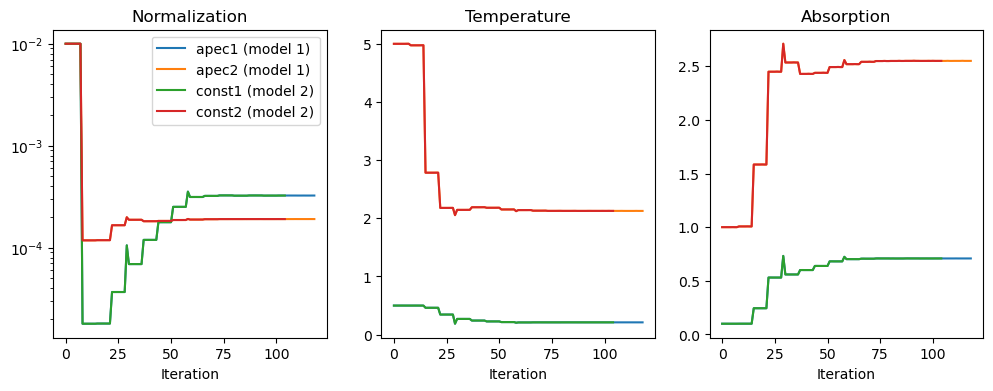

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].plot(tab["apec1.norm"], label="apec1 (model 1)")
axes[0].plot(tab["apec2.norm"], label="apec2 (model 1)")
axes[0].plot(tab2["const1.c0"], label="const1 (model 2)")
axes[0].plot(tab2["const2.c0"], label="const2 (model 2)")
axes[0].set_yscale("log")
axes[0].set_title("Normalization")
axes[0].legend()

axes[1].plot(tab["apec1.kT"])
axes[1].plot(tab["apec2.kT"])
axes[1].plot(tab2["apec21.kT"])
axes[1].plot(tab2["apec22.kT"])
axes[1].set_title("Temperature")

axes[2].plot(tab["abs1.nH"])
axes[2].plot(tab["abs2.nH"])
axes[2].plot(tab2["abs21.nH"])
axes[2].plot(tab2["abs22.nH"])
axes[2].set_title("Absorption")

for ax in axes:
    ax.set_xlabel("Iteration")

The plots above show the evolution of the parameters over the iterations of the fit. Since the use the same data, the same optimizer, and the same starting value it is not surprising that the steps are very similar, pratically falling on top of each other; the equivalent lines for the two plots are blue/green and orange/red and indeed it is difficult to spot the difference. That means that out timing comparison is meaningful - the second fit is faster because each step is evaluated faster, not because the optimizer found a shortcut somewhere.

For this specific model and optimizer, we can see that the git typically changes one of the values (sometimes by very small amounts such as 1e-5, which are not visible in the plot) and then keeps is constant while changing a different value. Looking in particular at the apec models (left and middle panel), the caching of model values takes care of the situation where the apec is called with exactly identical parameters and only one or both of the nH values are changed. In this case, the apec is not recalculated and the value is simply retrieved from the model cache, which is a very fast operation. However, in the fit 1 (blue/orange) the apec model is recalculated every time either the norm or the temperature is changed; in fit 2, the norm of the apec is frozen and its role taken by the `Scale1D` model, which is a much faster operation. Now, *only* changes in the temperature trigger a new apec calculation, which is a much less frequent event leading to the speed-up.

In [24]:
# The output of the cache_status method is suspect and might not be accurate
# Despite the reported size, this really acts as a size=1 cache in this run due to a known bug in caching:
# see https://github.com/sherpa/sherpa/pull/2166

for m in [apec1, apec2, apec21, apec22, const21, const22]:
    m.cache_status()

 apec1                      size:    5  hits:    12  misses:     7  check:    19
 apec2                      size:    5  hits:    12  misses:     7  check:    19
 apec21                     size:    5  hits:     9  misses:     3  check:    12
 apec22                     size:    5  hits:     9  misses:     3  check:    12
 const1                     size:    5  hits:     9  misses:     3  check:    12
 const2                     size:    5  hits:     9  misses:     3  check:    12


## Getting results

Because of the internal XSPEC cache, I can't just run the notebook to bottom, whatever model is run first will take longer. Thus, instead, I restart and just run the cells that I need and write down the run-time manually to make a fair comparison.

I try four scenarios and get the runtimes below. I've redone every scenario a number of times and the timing is stable; also the fits results are virtual indistinguishable (typically agree to 5 digits or so).

- Model 1, first fit after starting sherpa: 2.5 to 2.7 seconds, 117 function evaluations
- Model 2, first fit after starting sherpa: 2.3 seconds, 103 function evaluations
- Model 1, last of several runs (so the APEC internal cache is filled, but creating new model objects in Sherpa and resetting starting values every time): 1.0 seconds, 117 function evaluations
- Model 2, last of several runs (so the APEC internal cache is filled, but creating new model objects in Sherpa and resetting starting values every time): 0.7 seconds, 103 function evaluations



## Conclusion for APEC models

Model 1 needs 117/103 =1.136 as many evaluations, and it takes 2.6/2.3 =1.13 times as long (in a cold start), so we can conclude that there is no benefit to special case the the norm for XSPEC APEC class models. (But, looking at detailed timing using cPython's profiler, it also doesn't hurt that much - the biggest impact is running md5 to calculate the hash for the modelCacher1D which needs about 1% of the runtime.)

## Do all XSPEC models internally treat the norm?

If all XSPEC models treat the norm in the same way as the APEC models, then we can conclude that there is no benefit to special case the norm for XSPEC models.So, lets check that for other additative models.

In [3]:
from sherpa.astro import xspec

In [26]:
additative_model_list = xspec.XSAdditiveModel.__subclasses__()

# Short version for writing and testing the code below
additative_model_list_short = additative_model_list[:5]



In [4]:
en_bins = np.arange(0.2, 10.0, 0.01)


In [5]:
from collections import defaultdict

def measure_runtime(
    mdlclass, pars_to_vary=None, n=10, en_bins=np.arange(0.2, 10.0, 0.01)
):
    # do something, because models often initialize on first use
    mdl = mdlclass()
    flux = mdl(xlo=[1,2], xhi=[2, 3])

    # Then leave parameters on default values and change norm
    run_time = defaultdict(list)
    if pars_to_vary is None:
        pars_to_vary  = mdl.pars
    else:
        pars_to_vary.append("norm")
        pars_to_vary = [p for p in mdl.pars if p.name in pars_to_vary]
    defaults = [p.val for p in pars_to_vary]
    for i, par in enumerate(pars_to_vary):
        #if par.frozen:
        #    continue
        for pval in np.linspace(par.min, par.max, num=n):
            par.val = pval
            start_time = time.perf_counter()
            flux = mdl(xlo=en_bins[:-1], xhi=en_bins[1:])
            end_time = time.perf_counter()
            run_time[par.name].append(end_time - start_time)
            par.val = defaults[i]
    return run_time

In [6]:
def print_runtime_stats(run_time):
    for k, v in run_time.items():
        mean, median, stddev = sigma_clipped_stats(v)
        print(
            f"    {k:10}: {np.mean(v):.3g} +/- {np.std(v):.3g} seconds -- ({mean:.3g} +/- {stddev:.3g} (sigma clipped))"
        )

In [12]:
model_pars_to_test = {
    "XSagauss": None,
    "XSagnsed": ["mass", "astar", "cosi"],
    "XSagnslim": ["mass", "astar", "cosi"],
    "XSapec": None,
    "XSbbody": None,
    "XSbcempow": ["alpha", "Tmax", "nH", "velocity"],
    "XSbcie": ["kT", "Abundanc"],
    "XSbcoolflow": ["kT", "Abundanc", "Redshift"],
    "XScompTT": None,
    "XSpowerlaw": None,
    #"XSvlorentz": None,
}

In [13]:
mdlclass = "XSpowerlaw"
pars_to_vary = None
run_time = measure_runtime(getattr(xspec, mdlclass), pars_to_vary=pars_to_vary)
print_runtime_stats(run_time)

    PhoIndex  : 0.000129 +/- 5.39e-05 seconds -- (0.000129 +/- 5.39e-05 (sigma clipped))
    norm      : 9.5e-05 +/- 3.58e-06 seconds -- (9.38e-05 +/- 5.08e-07 (sigma clipped))


/Users/guenther/code/sherpa/sherpa/astro/xspec/__init__.py:1465: FutureWarning: calc() requires pars,lo,hi arguments, sent 2 arguments
  warnings.warn(emsg, FutureWarning)


In [ ]:
for mdlclass, pars_to_vary in model_pars_to_test.items():
    print(f"{mdlclass}")
    run_time = measure_runtime(getattr(xspec, mdlclass), pars_to_vary=pars_to_vary)
    print_runtime_stats(run_time)
 


XSagauss
    LineE     : 0.000201 +/- 7.6e-05 seconds -- (0.000176 +/- 5.61e-06 (sigma clipped))
    Sigma     : 0.000195 +/- 3.34e-05 seconds -- (0.000195 +/- 3.34e-05 (sigma clipped))
    norm      : 0.000177 +/- 4.12e-05 seconds -- (0.000164 +/- 1.38e-05 (sigma clipped))
XSagnsed


/Users/guenther/code/sherpa/sherpa/astro/xspec/__init__.py:1465: FutureWarning: calc() requires pars,lo,hi arguments, sent 2 arguments
  warnings.warn(emsg, FutureWarning)
/Users/guenther/code/sherpa/sherpa/astro/xspec/__init__.py:1465: FutureWarning: calc() requires pars,lo,hi arguments, sent 2 arguments
  warnings.warn(emsg, FutureWarning)


    mass      : 0.133 +/- 0.0202 seconds -- (0.124 +/- 0.00287 (sigma clipped))
    astar     : 0.134 +/- 0.00383 seconds -- (0.133 +/- 0.000814 (sigma clipped))
    cosi      : 0.132 +/- 0.00063 seconds -- (0.132 +/- 0.00063 (sigma clipped))
    norm      : 0.13 +/- 0.00192 seconds -- (0.13 +/- 0.00192 (sigma clipped))
XSagnslim


/Users/guenther/code/sherpa/sherpa/astro/xspec/__init__.py:1465: FutureWarning: calc() requires pars,lo,hi arguments, sent 2 arguments
  warnings.warn(emsg, FutureWarning)


    mass      : 0.102 +/- 0.00308 seconds -- (0.1 +/- 0.000368 (sigma clipped))
    astar     : 0.102 +/- 0.000346 seconds -- (0.102 +/- 0.000346 (sigma clipped))
    cosi      : 0.103 +/- 0.000319 seconds -- (0.103 +/- 0.000319 (sigma clipped))
    norm      : 0.103 +/- 0.000239 seconds -- (0.103 +/- 0.000114 (sigma clipped))
XSapec
Reading APEC data from 3.0.9



/Users/guenther/code/sherpa/sherpa/astro/xspec/__init__.py:1465: FutureWarning: calc() requires pars,lo,hi arguments, sent 2 arguments
  warnings.warn(emsg, FutureWarning)


    kT        : 0.0633 +/- 0.0333 seconds -- (0.0523 +/- 0.00576 (sigma clipped))
    Abundanc  : 0.0156 +/- 0.00387 seconds -- (0.0168 +/- 0.00011 (sigma clipped))
    Redshift  : 0.00726 +/- 0.00388 seconds -- (0.00726 +/- 0.00388 (sigma clipped))
    norm      : 0.0169 +/- 0.000177 seconds -- (0.0169 +/- 0.000177 (sigma clipped))
XSbbody
    kT        : 5.63e-05 +/- 4.44e-05 seconds -- (3.52e-05 +/- 1.38e-06 (sigma clipped))
    norm      : 3.45e-05 +/- 5.02e-07 seconds -- (3.43e-05 +/- 1.74e-07 (sigma clipped))
XSbcempow


/Users/guenther/code/sherpa/sherpa/astro/xspec/__init__.py:1465: FutureWarning: calc() requires pars,lo,hi arguments, sent 2 arguments
  warnings.warn(emsg, FutureWarning)
/Users/guenther/code/sherpa/sherpa/astro/xspec/__init__.py:1465: FutureWarning: calc() requires pars,lo,hi arguments, sent 2 arguments
  warnings.warn(emsg, FutureWarning)






    alpha     : 0.188 +/- 0.0178 seconds -- (0.183 +/- 0.00262 (sigma clipped))
    Tmax      : 0.854 +/- 1.37 seconds -- (0.4 +/- 0.159 (sigma clipped))
    nH        : 0.188 +/- 0.00338 seconds -- (0.188 +/- 0.00338 (sigma clipped))
    norm      : 0.187 +/- 0.0032 seconds -- (0.187 +/- 0.0032 (sigma clipped))
XSbcie


/Users/guenther/code/sherpa/sherpa/astro/xspec/__init__.py:1465: FutureWarning: calc() requires pars,lo,hi arguments, sent 2 arguments
  warnings.warn(emsg, FutureWarning)


    kT        : 0.0042 +/- 0.000435 seconds -- (0.0042 +/- 0.000435 (sigma clipped))
    Abundanc  : 0.0183 +/- 0.00478 seconds -- (0.0199 +/- 0.00011 (sigma clipped))
    norm      : 0.0204 +/- 0.000645 seconds -- (0.0204 +/- 0.000645 (sigma clipped))
XSbcoolflow


/Users/guenther/code/sherpa/sherpa/astro/xspec/__init__.py:1465: FutureWarning: calc() requires pars,lo,hi arguments, sent 2 arguments
  warnings.warn(emsg, FutureWarning)



 BVCOOLFLOW: Require z > 0 for cooling flow models
    Abundanc  : 0.345 +/- 0.0859 seconds -- (0.374 +/- 0.00157 (sigma clipped))
    Redshift  : 0.286 +/- 0.0976 seconds -- (0.318 +/- 0.0215 (sigma clipped))
    norm      : 0.374 +/- 0.000613 seconds -- (0.374 +/- 0.000613 (sigma clipped))
XScompTT
    Redshift  : 0.000306 +/- 0.000109 seconds -- (0.000273 +/- 4.72e-05 (sigma clipped))
    T0        : 0.000243 +/- 2.02e-06 seconds -- (0.000243 +/- 2.02e-06 (sigma clipped))
    kT        : 0.00028 +/- 2.11e-05 seconds -- (0.000273 +/- 6.03e-06 (sigma clipped))
    taup      : 0.000263 +/- 6.42e-06 seconds -- (0.000263 +/- 6.42e-06 (sigma clipped))
    approx    : 0.000268 +/- 9.75e-07 seconds -- (0.000268 +/- 4.81e-07 (sigma clipped))
    norm      : 0.000271 +/- 5.34e-06 seconds -- (0.000271 +/- 5.34e-06 (sigma clipped))


/Users/guenther/code/sherpa/sherpa/astro/xspec/__init__.py:1465: FutureWarning: calc() requires pars,lo,hi arguments, sent 2 arguments
  warnings.warn(emsg, FutureWarning)


First a few notes. Those notes are based on things that I explored interactively but I'm not keeping every step here in order to keep the notebook more readable:

- Redshift can change the number of spectral bins that a model considers or where a model actually needs to perform calculation. So, changing the redshift is often "fast", but that's not because it's a fast, buffered operations, it's because the number of bins for which anything needs to be calculated is changing. Note true for all, but for some models.
- Internal cache: There are **a lot** of models that use (or can use, depending on the setting) APEC underneath. I suspect that they all share the same internal cache and often the same steps in energy etc., so that the cache is still filled when the latter models are run.

## Interpretation
We can think of XSPEC models falling into broad categories:

- Fast analytic models, e.g. `XSgauss`, `XSlorentz`, `XSpowerlaw`. Runtime obviously depends on the number of bins etc, but with the grid above they need of order 1e-4 s for evaluation and evaluate at the same speed for all parameters. Cashing is probably irrelavant, but also not necessarily harmful (spend time on hash calculation, but cache look-up is even faster than evaluation) beyond the memory use.
- APEC-type models with internal cache. As shown above in this notebook, the internal cache is very effective; using an extra sherpa cache neither harms nor helps in real fitting situations.
- Models that have a significant runtime (e.g. `XSbcoolflow`) and where the "norm" parameter is not any faster than the other parameters; those might be good candidates to speed up with special treatment of the norm parameter. 

### A thought of caution
However, have to be careful here - do we know that the "norm" parameter is always just a scalar factor and that we don't have e.g. effects of optical depth or curve-of-growth? That's something we need to either understand per model or at least test for a wide range of input parameters.

### Experiment: Can I speed up `XSbcoolflow` with a strategy similar to what I tried before for APEC?

If I want an end-to-end comparison, I need a dataset to fit. I don't think we have one that looks reasonable, so I'll create one in a simulation. It seems that the model does not do a lot of internal caching (otherwise I would expect it to be faster) so hopefully I don't have to restart the kernel every time to get a fair comparison.

In [3]:
# Load some dataset so we have an arf and rmf in memory
ui.load_pha(
    3, "../curated-test-data/Chandra/ACIS/acisf04487_001N023_r0009_pha3.fits.gz"
)


read ARF file ../curated-test-data/Chandra/ACIS/acisf04487_001N022_r0009_arf3.fits
read RMF file ../curated-test-data/Chandra/ACIS/acisf04487_001N022_r0009_rmf3.fits
read background file ../curated-test-data/Chandra/ACIS/acisf04487_001N023_r0009_pha3.fits


In [ ]:
coolflow = xspec.XSbcoolflow("coolflow")

<XSbcoolflow model instance 'coolflow'>

In [5]:
# Change some numbers so that there is something to fit later
coolflow.lowT = 0.23
coolflow.highT = 3.45
coolflow.Abundanc = 0.3
coolflow.norm = 12.34


ui.set_source(3, coolflow)

In [6]:
ui.fake_pha(
    3,
    "../curated-test-data/Chandra/ACIS/acisf04487_001N022_r0009_arf3.fits",
    "../curated-test-data/Chandra/ACIS/acisf04487_001N022_r0009_rmf3.fits",
    2e4,
)
ui.notice_id(3, 0.3, 7)
ui.group_counts(3, 5)

Reading APEC data from 3.0.9

dataset 3: 0.0073:14.9504 -> 0.292:7.008 Energy (keV)
dataset 3: 0.292:7.008 Energy (keV) (unchanged)


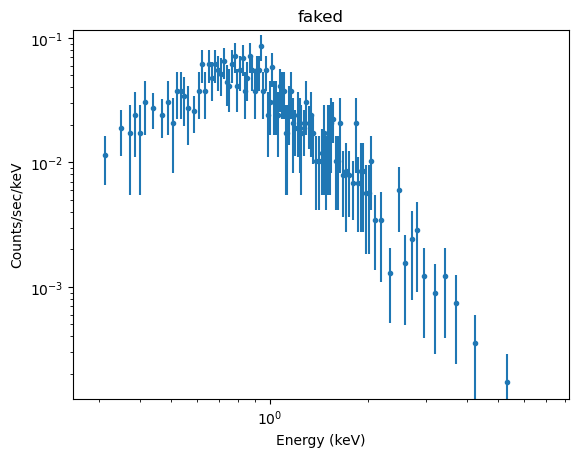

In [8]:
ui.plot_data(3, xlog=True, ylog=True)

In [9]:
from sherpa.models.basic import Scale1D

coolflow2 = xspec.XSbcoolflow("coolflow2")
coolflow2.norm.freeze()
scale2 = Scale1D("scale2")
scale2._use_caching = False  # see below
model2 = scale2 * coolflow2

coolflow3 = xspec.XSbcoolflow("coolflow3")

In [ ]:
ui.set_source(3, model2)

start_time2 = time.perf_counter()
ui.fit(3)
end_time2 = time.perf_counter()
print(end_time2 - start_time2, "seconds")


Dataset               = 3
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 438.374
Final fit statistic   = 39.9601 at function evaluation 199
Data points           = 101
Degrees of freedom    = 97
Probability [Q-value] = 1
Reduced statistic     = 0.41196
Change in statistic   = 398.414
   scale2.c0      14.9689      +/- 4.55393     
   coolflow2.lowT   0.294771     +/- 0.292456    
   coolflow2.highT   2.75903      +/- 0.546765    
   coolflow2.Abundanc   0.15704      +/- 0.0885668   
53.619376457994804 seconds


In [11]:
ui.set_source(3, coolflow3)

start_time = time.perf_counter()
ui.fit(3)
end_time = time.perf_counter()
print(end_time - start_time, "seconds")


Dataset               = 3
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 438.374
Final fit statistic   = 39.9601 at function evaluation 208
Data points           = 101
Degrees of freedom    = 97
Probability [Q-value] = 1
Reduced statistic     = 0.41196
Change in statistic   = 398.414
   coolflow3.lowT   0.294754     +/- 0.298478    
   coolflow3.highT   2.75887      +/- 0.549834    
   coolflow3.Abundanc   0.157026     +/- 0.0893689   
   coolflow3.norm   14.9704      +/- 4.59341     
61.2401770830038 seconds


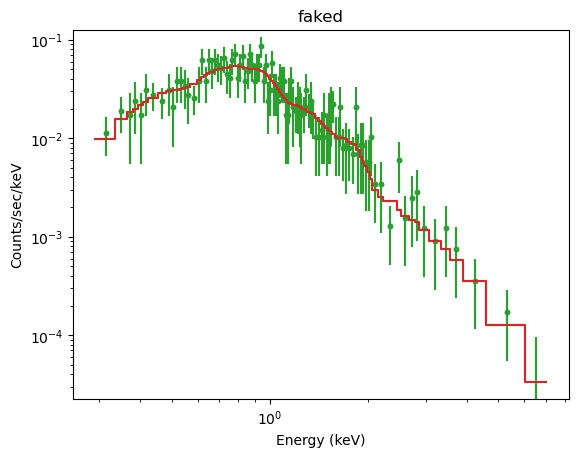

In [12]:
ui.set_source(3, coolflow3)
ui.plot_fit(3, xlog=True, ylog=True)
ui.set_source(3, model2)
ui.plot_fit(3, overplot=True)

In [14]:
coolflow2._cache_ctr, coolflow3._cache_ctr

({'hits': 40, 'misses': 163, 'check': 204},
 {'hits': 4, 'misses': 208, 'check': 213})

In [20]:
print(f'Runtime per step: {53.6 / 199:.2f}, {61.2 / 208:.2f}')
print(f"Runtime per cooling flow cache hit: {53.6 / 163:.2f}, {61.2 / 208:.2f}")

Runtime per step: 0.27, 0.29
Runtime per cooling flow cache hit: 0.33, 0.29


While I could get the runtime and the number of fev from Python, I've simple written down the numbers form one particular run in the print statements in the cell above. 

We can see three things:
- The `scale*coolingflow` model converges in fewer steps than the `coolingflow` models alone. I've seen even more extreme cases of that, sometimes the coolingflow model along doesn't even find the right minimum; in all cases I've tried either the `scale*coolingflow` model is better or equal to the alternative, similar to the `scale*apec` vs. `apec` model higher up in this notebook. I suspect that the scale alone has a higher numerical precision than passing the norm to XSPEC and back and that that helps the optimizer in some way.
- Per function evaluation, the `scale*coolingflow` model is faster by about 8%, because the XSPEC model is not called as often due to hitting the cache.
- Per XSPEC call (=cache miss) the `scale*coolingflow` is about 12% slower, because the model is more complex (it's a `BinaryOpModel` of two components.) This penalty will go away if we implement a special treatment of the norm in the coolingflow model itself, so we can expect that the true speed up will better than 8%.

### Aside: Caching `Scale1D`

In the code above, we set `scale2._use_caching=False`. Why? Because in earlier experiments I found that there is a significant time loss from caching this seemingly simple function. Here, we just want to fit a scalar scale factor. There is nothing faster then just multiplying with a scalar. However, in the internal hirachy of models `Scale1D` derives from `Const1D` and has a special effected if the `integrate` setting is set to true (which is hopefully isn't because that would mess up the fit). `Scale1D` inherits the cache setting from `Const1D` and now needs to calculate the hash for every call, if it's a "hit" or not, slowing down the model by about a factor of 6 as we can see below. While it's not dominating the overall fit, it's noticable in the run-time for a model where I use the scale to replace the norm.

In [ ]:
from sherpa.models.basic import Scale1D
newscale = Scale1D("newscale")
%timeit newscale(xlo=np.arange(1000), xhi=np.arange(1000) + 1)
newscale._use_caching = False
%timeit newscale(xlo=np.arange(1000), xhi=np.arange(1000) + 1)

29.7 μs ± 205 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
5.67 μs ± 50.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
